## Group 3 - Project 2
# Online Shopper Purchase Prediction

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import model as Group3Models

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier



In [2]:
#Read in CSV
online_shopping_df = pd.read_csv('online_shoppers_intention.csv')

online_shopping_df.info()

online_shopping_df["Revenue"].value_counts()

# online_shopping_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [3]:
online_shopping_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Visualize PCA

In [4]:
pca_model = PCA(n_components=2)

<Axes: xlabel='OperatingSystems', ylabel='Count'>

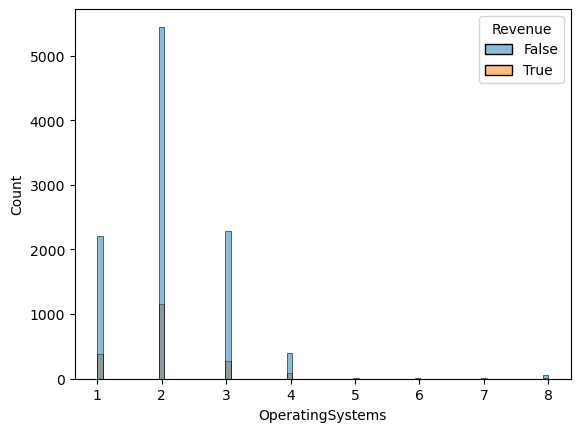

In [5]:
#EDA
sns.histplot(data=online_shopping_df, x='OperatingSystems', hue='Revenue')

<Axes: xlabel='ExitRates', ylabel='Count'>

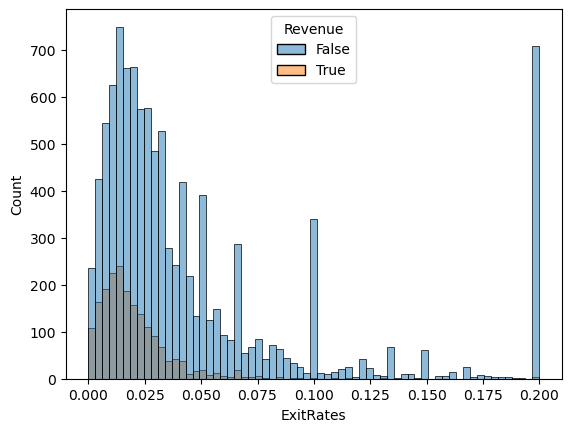

In [6]:
sns.histplot(data=online_shopping_df, x='ExitRates', hue='Revenue')

In [7]:
#Drop the target column, setup X and y datasets for train test split
X = online_shopping_df.drop('Revenue', axis=1)
y = online_shopping_df['Revenue']

X.head()

#Train Test Split
X_test, X_train, y_test, y_train = train_test_split(X, y)
X_train.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000,3083.000000
mean,2.232566,80.593469,0.510217,35.656326,30.233539,1159.658627,0.022291,0.043529,5.398714,0.062796,2.116121,2.377879,3.140123,4.007785
std,3.265071,185.128069,1.251920,147.484215,43.317272,2037.005384,0.048746,0.048633,17.166054,0.201489,0.915373,1.788344,2.411541,3.972726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,179.250000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,5.000000,0.000000,0.000000,17.000000,565.416667,0.003047,0.025926,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,3.000000,92.585714,0.000000,0.000000,35.500000,1399.043750,0.016667,0.050000,0.000000,0.000000,2.000000,2.000000,4.000000,4.000000
max,26.000000,3398.750000,14.000000,2549.375000,686.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


## Add Encodings to Feature Columns

In [8]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
X_train['VisitorType'] = ordinal_encoder.fit_transform(X_train[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_train['Month'] = ordinal_encoder.fit_transform(X_train[['Month']])
X_train.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
1917,1,51.0,2,117.285714,15,969.102381,0.005882,0.008889,0.0,0.0,2.0,3,3,1,2,2.0,False
12304,0,0.0,0,0.000000,30,655.542857,0.006667,0.019667,0.0,0.0,11.0,3,2,1,2,2.0,True
6393,1,64.4,0,0.000000,22,2364.650000,0.000000,0.043478,0.0,0.0,9.0,2,2,1,2,2.0,False
10107,1,43.5,0,0.000000,79,2006.834416,0.002532,0.006439,0.0,0.0,10.0,3,3,1,3,2.0,True
5143,0,0.0,0,0.000000,19,725.900000,0.000000,0.005263,0.0,0.0,4.0,1,2,1,4,2.0,False


In [9]:
#Encode VisitorType Column
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_test[['VisitorType']])
X_test['VisitorType'] = ordinal_encoder.transform(X_test[['VisitorType']])

#Ordinal Encode the Month Column
ordinal_encoder = OrdinalEncoder(categories=[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']])
X_test['Month'] = ordinal_encoder.fit_transform(X_test[['Month']])

<Axes: >

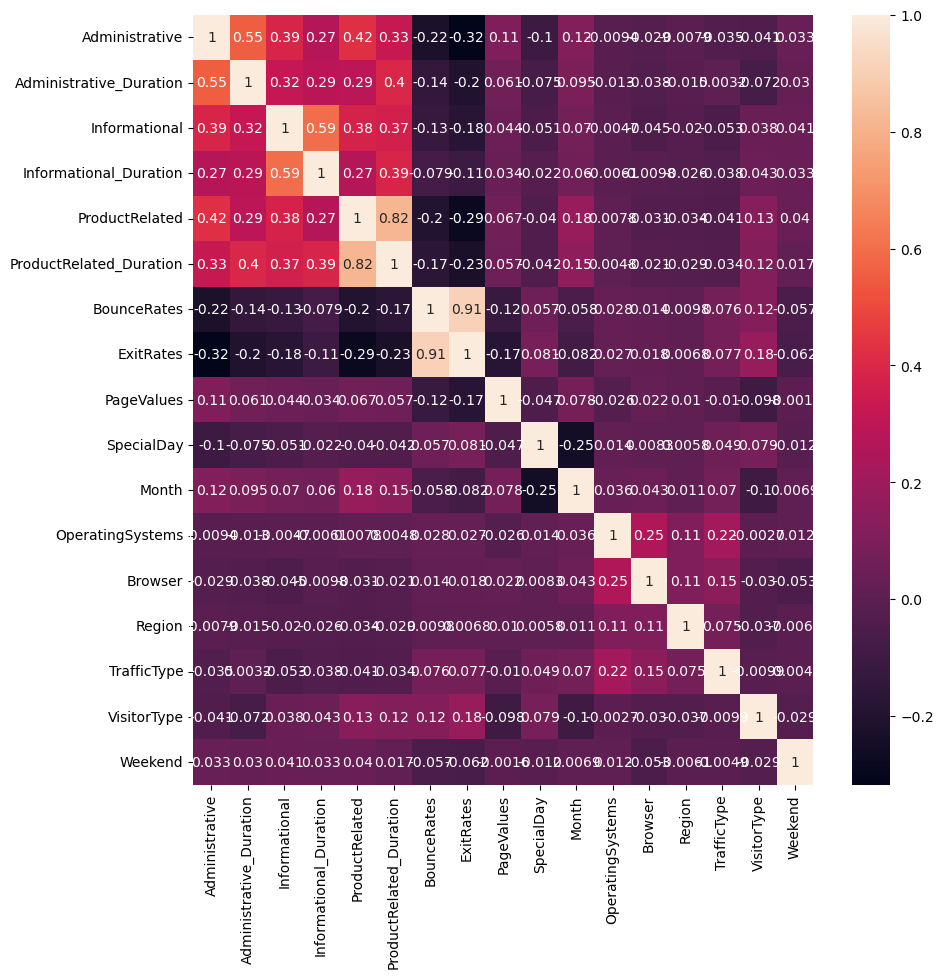

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=X_train.corr(), annot=True)

## Create a Model and predict

In [11]:
#Create a Random Forest Classifier
model = Group3Models.don_model()
model.fit(X_train, y_train)
print(model.score(X_test, y_test))
y_pred = model.predict(X_test)

0.8978046934140802


In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.97      0.94      7778
        True       0.77      0.51      0.61      1469

    accuracy                           0.90      9247
   macro avg       0.84      0.74      0.78      9247
weighted avg       0.89      0.90      0.89      9247



Accuracy Score: 0.8913161025197361
Balanced Accuracy Score: 0.7448969366216105
              precision    recall  f1-score   support

       False       0.92      0.96      0.94      7778
        True       0.71      0.53      0.61      1469

    accuracy                           0.89      9247
   macro avg       0.81      0.74      0.77      9247
weighted avg       0.88      0.89      0.88      9247



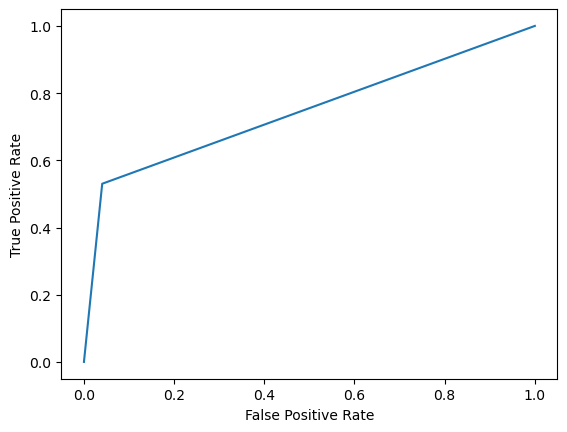

AUC Score: 0.7448969366216105


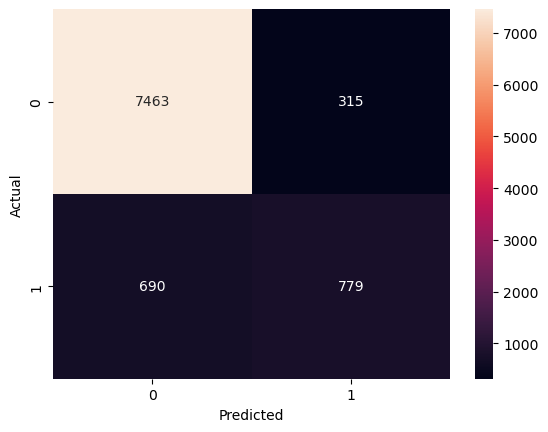

In [13]:
model = Group3Models.XGBoost_V1()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, X_test, y_test)

Accuracy Score: 0.8861252298042609
Balanced Accuracy Score: 0.7476090686040693
              precision    recall  f1-score   support

       False       0.92      0.95      0.93      7778
        True       0.68      0.54      0.60      1469

    accuracy                           0.89      9247
   macro avg       0.80      0.75      0.77      9247
weighted avg       0.88      0.89      0.88      9247



c:\Users\hunte\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


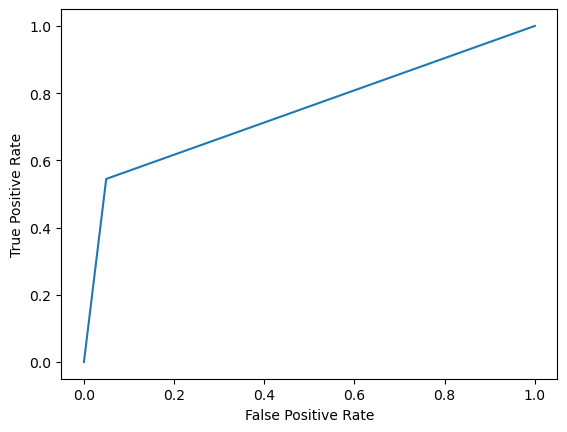

AUC Score: 0.7476090686040693


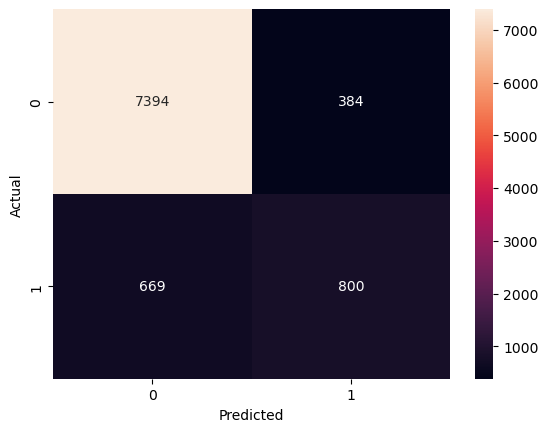

In [14]:
model = Group3Models.ADABoost_V1()
model.fit(X_train, y_train)
Group3Models.evaluate_model(model, X_test, y_test)